In [419]:
from __future__ import absolute_import, division, print_function
import os
from scipy.io import loadmat
import arff
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler


from sklearn.svm import NuSVC, SVC
from sklearn.svm import libsvm
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import RUSBoostClassifier

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

## Feature Paths

In [3]:
FBANK_feat = os.path.join('FBANK','binnedFeat.mat')
FBANK_label = os.path.join('FBANK','binnedLabels.csv')
ComParE_feat = os.path.join('baseline','openSMILEall_PCG.mat')
BOAW_feat = os.path.join('baseline_boaw','feat','boawFeat.4096.arff')
BOAW_meta = os.path.join('baseline_boaw','feat','BOAW_filenames.txt')

In [ ]:
def severe2abnormal(labels):
    for idx,each in enumerate(labels):
        if each == 2:
            labels[idx]=1
    return labels

## Data Loading

In [ ]:
# df = pd.read_csv('/media/taufiq/Data1/heart_sound/heartnet/featGen/mfcc.csv',header=None, delimiter=';')
# df.head()
# with open('/media/taufiq/Data1/heart_sound/heartnet/featGen/BOAW_filenames.txt','w') as fp:
#     for each in df[0].drop_duplicates().values:
#         fp.write("%s\n" % each)

In [237]:
## Load_BOAW:

df = arff.load(open(BOAW_feat,'r'))
boawData = pd.DataFrame(np.array(df['data'],dtype=float))
del df

boawFilenames = []
with open(BOAW_meta, 'r') as fp:
    line = fp.readline()
    boawFilenames.append(line.split('\n')[0])
    while line:
            line = fp.readline()
            boawFilenames.append(line.split('\n')[0])
boawFilenames = boawFilenames[:-1]
boawData['filenames'] = boawFilenames
boawData.rename({len(boawData.columns)-2:'label'},axis='columns',inplace=True)
boawData.label = [int(each) for each in boawData.label]
boawData['dataset'] = [each[-1][0] for each in boawData.filenames.str.split('_')]
boawData.set_index('filenames',drop=True,inplace=True)

del boawFilenames
boawData.shape

(3835, 4098)

In [208]:
## Load FBANK: 

df = loadmat(FBANK_feat)
fbankData = pd.DataFrame(df['feats'])
fbankMeta = pd.read_csv(FBANK_label)
fbankMeta.file_name = [each[0] for each in fbankMeta.file_name.str.split('.')]
fbankData = fbankData.join(fbankMeta)
fbankData.dropna(inplace=True)
fbankData.rename({'file_name':'filenames'},axis="columns",inplace=True)
fbankData.label = [int(each) for each in fbankData.label]
fbankData['dataset'] = [each[-1][0] for each in fbankData.filenames.str.split('_')]
fbankData.set_index('filenames',drop=True,inplace=True)

del df, fbankMeta

fbankData.shape

(3835, 2709)

In [206]:
## Load ComParE:

df = loadmat(ComParE_feat)

compareData = pd.DataFrame(df['dataTrain'])
compareData = pd.concat((compareData,pd.DataFrame(df['dataDev'])),axis="rows").reset_index(drop=True)
compareData['label'] = np.concatenate((np.hstack(df['TrainLabels']),np.hstack(df['DevLabels'])),axis=0)
compareData['filenames'] = np.concatenate((np.hstack(df['TrainFiles']),np.hstack(df['DevFiles'])),axis=0)
compareData.filenames = [each[0] for each in compareData.filenames.str.split('.')]
compareData.label = [int(each) for each in compareData.label]
compareData['dataset'] = [each[-1][0] for each in compareData.filenames.str.split('_')]
compareData.set_index('filenames',drop=True,inplace=True)

del df

compareData.shape

(3835, 6375)

## Under-Sampling

In [62]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]0.4714285714285714
0.0


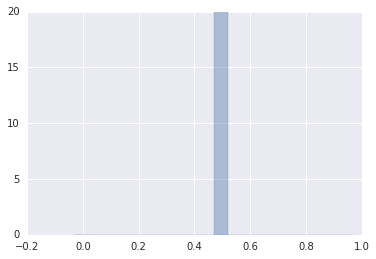

In [180]:
dataset = '0'

np.random.seed(1)
rand_states = np.random.randint(20000,size=(10,))
scaler = StandardScaler()
mask = compareData.dataset == dataset
X_ = scaler.fit_transform(compareData[range(6373)][mask]) ## .4489999
results = []
for rand_state in rand_states:
    rand_state = 144
    rus = RandomUnderSampler(random_state=rand_state)    
    X,y = rus.fit_resample(X_,compareData.label[mask])
    
    clf = NuSVC(kernel='linear',probability=True,verbose=True,
              random_state=rand_state, nu = .3)
    
    X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                      test_size = 0.2,
                                                      random_state = rand_state,
                                                      shuffle = True)
    clf.fit(X_train,y_train)
    
    results.append(accuracy_score(clf.predict(X_val), y_val))
print(np.mean(results))
print(np.std(results))

sns.distplot(results,20)
plt.show()

In [178]:
zip(rand_states,results)

[(235, 0.7872340425531915),
 (12172, 0.723404255319149),
 (5192, 0.7446808510638298),
 (17289, 0.7446808510638298),
 (10955, 0.6808510638297872),
 (7813, 0.6808510638297872),
 (19279, 0.6808510638297872),
 (144, 0.851063829787234),
 (16332, 0.7021276595744681),
 (7751, 0.7659574468085106)]

In [137]:
C_grid = [0.0001 0.001, 0.01, 0.1, 1, 10]
# gamma_grid = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': C_grid}

grid = GridSearchCV(fbankBbc, param_grid, cv = 4, scoring = "accuracy")
grid.fit(X, y)

print(grid.best_score_)

print(grid.best_params_)

print(grid.best_estimator_)

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=19433,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [248]:
dataset = '0'


scaler = StandardScaler()
mask = compareData.dataset == dataset
X = scaler.fit_transform(compareData[range(6373)][mask]) ## .4489999
y = compareData.label[mask]

clf = NuSVC(kernel='linear',probability=True,verbose=False,
          random_state=144,
            nu = .5)

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size = 0.3,
                                                  random_state = 114,
                                                  shuffle = True)
bbc = BalancedBaggingClassifier(base_estimator=clf,
                                n_estimators=100,
                                oob_score = True,
                                random_state=114,
                               )
bbc.fit(X_train,y_train)
print("Out of Bag Score &f" % bbc.oob_score_)
print("Validation split accuracy &f" % accuracy_score(bbc.predict(X_val), y_val))

NameError: name 'compareData' is not defined

# Fuse Dataframes

In [244]:
## Fuse dataframes

print("Target Size %d" % (len(boawData.columns)-2+len(fbankData.columns)-2+len(compareData.columns)))
fused = boawData[range(len(boawData.columns)-2)].join(fbankData[range(len(fbankData.columns)-2)],rsuffix='fbank')
fused = fused.join(compareData,lsuffix='fused')
fused.dropna()
fused.columns = range(len(fused.columns))
fused.rename({len(fused.columns)-2:'label',len(fused.columns)-1:'dataset'},axis="columns",inplace=True)

del boawData, fbankData, compareData

fused.head()

Target Size 13178


### Random Validation Split

In [322]:
rand_state = 114
n_estimators = 10
dataset = '0'

scaler = StandardScaler()
mask = fused.dataset == dataset

X = scaler.fit_transform(fused[range(len(fused.columns)-2)][mask]) ## .4489999
y = fused.label[mask]

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size = 0.3,
                                                  random_state = rand_state,
                                                  shuffle = True)

### Dev set of Compare

In [441]:
rand_state = 1
dataset = '0'

scaler = StandardScaler()
mask1 = fused.dataset == dataset
mask2 = fused[mask1].index.str.contains('train')
mask3 = fused[mask1].index.str.contains('devel')

X = scaler.fit_transform(fused[range(len(fused.columns)-2)][mask1]) ## .4489999
y = fused.label[mask1]

X_train = X[mask2]
y_train = y[mask2]
X_val = X[mask3]
y_val = y[mask3]

del mask1, mask2, mask3, X, y

### Fold1_noFIR

In [458]:
rand_state = 1
n_estimators = 5

fold1_val = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/validation1.txt'
df = pd.read_csv(fold1_val,header=None)
df[0] = ['train_'+each for each in df[0]]
df.columns = ['filenames']
df.set_index('filenames',drop=True,inplace=True)
mask = fused.dataset == '0'
fold1_data = fused[~mask]

mask1 = [each in df.index.values for each in fold1_data.index.values]
mask2 = [not each for each in mask1]
X = scaler.fit_transform(fold1_data[range(len(fold1_data.columns)-2)])
y = fold1_data.label
del fold1_data

X_train = X[mask2]
y_train = y[mask2]
X_val = X[mask1]
y_val = y[mask1]

del mask, mask1, mask2, X, y

### Fold2_noFIR

In [458]:
rand_state = 1
n_estimators = 5

fold1_val = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/validation2.txt'
df = pd.read_csv(fold1_val,header=None)
df[0] = ['train_'+each for each in df[0]]
df.columns = ['filenames']
df.set_index('filenames',drop=True,inplace=True)
mask = fused.dataset == '0'
fold1_data = fused[~mask]

mask1 = [each in df.index.values for each in fold1_data.index.values]
mask2 = [not each for each in mask1]
X = scaler.fit_transform(fold1_data[range(len(fold1_data.columns)-2)])
y = fold1_data.label
del fold1_data

X_train = X[mask2]
y_train = y[mask2]
X_val = X[mask1]
y_val = y[mask1]

del mask, mask1, mask2, X, y

### Fold3_noFIR

In [458]:
rand_state = 1
n_estimators = 5

fold1_val = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/validation3.txt'
df = pd.read_csv(fold1_val,header=None)
df[0] = ['train_'+each for each in df[0]]
df.columns = ['filenames']
df.set_index('filenames',drop=True,inplace=True)
mask = fused.dataset == '0'
fold1_data = fused[~mask]

mask1 = [each in df.index.values for each in fold1_data.index.values]
mask2 = [not each for each in mask1]
X = scaler.fit_transform(fold1_data[range(len(fold1_data.columns)-2)])
y = fold1_data.label
del fold1_data

X_train = X[mask2]
y_train = y[mask2]
X_val = X[mask1]
y_val = y[mask1]

del mask, mask1, mask2, X, y

### Fold0_noFIR

In [458]:
rand_state = 1
n_estimators = 5

fold1_val = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/validation0.txt'
df = pd.read_csv(fold1_val,header=None)
df[0] = ['train_'+each for each in df[0]]
df.columns = ['filenames']
df.set_index('filenames',drop=True,inplace=True)
mask = fused.dataset == '0'
fold1_data = fused[~mask]

mask1 = [each in df.index.values for each in fold1_data.index.values]
mask2 = [not each for each in mask1]
X = scaler.fit_transform(fold1_data[range(len(fold1_data.columns)-2)])
y = fold1_data.label
del fold1_data

X_train = X[mask2]
y_train = y[mask2]
X_val = X[mask1]
y_val = y[mask1]

del mask, mask1, mask2, X, y

In [459]:
def verboseMetrics(y_val,softScores):
    eps = 1.1e-5
    if Counter(y_val).keys()[-1] == 1:
        TN, FP, FN, TP = confusion_matrix(y_val, np.argmax(softScores,axis=-1), labels=[0,1]).ravel()
        sensitivity = TP / (TP + FN + eps)
        specificity = TN / (TN + FP + eps)
        precision = TP / (TP + FP + eps)
        F1 = 2 * (precision * sensitivity) / (precision + sensitivity + eps)
        Macc = (sensitivity + specificity) / 2
        print("TN:{},FP:{},FN:{},TP:{},Sensitivity:{},Specificity{},Macc:{},F1:{}".format(TN, FP, FN, TP,sensitivity,specificity,Macc,F1))
    elif Counter(y_val).keys()[-1] == 2:
        logs = dict()
        confmat = confusion_matrix(y_pred=np.argmax(softScores,axis=-1), y_true=y_val)
        logs['recall0'] = confmat[0, 0] / np.sum(confmat[0, :])
        logs['recall1'] = confmat[1, 1] / np.sum(confmat[1, :])
        logs['recall2'] = confmat[2, 2] / np.sum(confmat[2, :])
        logs['UAR'] = np.mean([logs['recall0'], logs['recall1'], logs['recall2']])
        print(logs.items())

## Undersampling

In [460]:
n_estimators = 100

In [461]:
## BOAW Train
del clf

clf = NuSVC(kernel='linear',probability=True,verbose=False,
          random_state=rand_state,
            nu = .5)

boawBbc = BalancedBaggingClassifier(base_estimator=clf,
                                n_estimators=n_estimators,
                                oob_score = True,
                                random_state=rand_state,
                                sampling_strategy = 'not minority'
                               )
boawBbc.fit(X_train[:,:4096],y_train)
print("Out of Bag Score Boaw %f" % boawBbc.oob_score_)
print("Validation split accuracy Boaw %f" % accuracy_score(y_val,boawBbc.predict(X_val[:,:4096])))
verboseMetrics(y_val,boawBbc.predict_proba(X_val[:,:4096]))

Out of Bag Score Boaw 0.827464
Validation split accuracy Boaw 0.894737
TN:143,FP:28,FN:8,TP:163,Sensitivity:0.953216312951,Specificity0.836257256147,Macc:0.894736784549,F1:0.90054694828


In [462]:
## Fbank Train
del clf

clf = NuSVC(kernel='linear',probability=True,verbose=False,
          random_state=rand_state,
            nu = .5)

fbankBbc = BalancedBaggingClassifier(base_estimator=clf,
                                n_estimators=n_estimators,
                                oob_score = True,
                                random_state=rand_state,
                                sampling_strategy = 'not minority'
                               )
fbankBbc.fit(X_train[:,4096:4096+2707],y_train)
print("Out of Bag Score Fbank %f" % fbankBbc.oob_score_)
print("Validation split accuracy Fbank %f" % accuracy_score(y_val,fbankBbc.predict(X_val[:,4096:4096+2707])))
verboseMetrics(y_val,fbankBbc.predict_proba(X_val[:,4096:4096+2707]))

Out of Bag Score Fbank 0.739950
Validation split accuracy Fbank 0.792398
TN:125,FP:46,FN:25,TP:146,Sensitivity:0.853801114668,Specificity0.730994105024,Macc:0.792397609846,F1:0.804402183191


In [463]:
## Compare Train
del clf

clf = NuSVC(kernel='linear',probability=True,verbose=False,
          random_state=rand_state,
            nu = .5)

compareBbc = BalancedBaggingClassifier(base_estimator=clf,
                                n_estimators=n_estimators,
                                oob_score = True,
                                random_state=rand_state,
                                sampling_strategy = 'not minority',
                               )
compareBbc.fit(X_train[:,4096+2707:],y_train)
print("Out of Bag Score Compare %f" % compareBbc.oob_score_)
print("Validation split accuracy Compare %f" % accuracy_score(y_val, compareBbc.predict(X_val[:,4096+2707:])))
verboseMetrics(y_val,compareBbc.predict_proba(X_val[:,4096+2707:]))

Out of Bag Score Compare 0.840270
Validation split accuracy Compare 0.888889
TN:144,FP:27,FN:11,TP:160,Sensitivity:0.93567245443,Specificity0.842105208987,Macc:0.888888831709,F1:0.893849204693


In [464]:
## Weighted fusion posteriors

weights = [.92,.055,.025]

softScores = boawBbc.predict_proba(X_train[:,:4096])*weights[1]+fbankBbc.predict_proba(X_train[:,4096:4096+2707])*weights[2]+compareBbc.predict_proba(X_train[:,4096+2707:])*weights[0]
print("Training accuracy Combination %f" % accuracy_score(y_train, np.argmax(softScores,axis=-1)))
verboseMetrics(y_train,softScores)

softScores = boawBbc.predict_proba(X_val[:,:4096])*weights[1]+fbankBbc.predict_proba(X_val[:,4096:4096+2707])*weights[2]+compareBbc.predict_proba(X_val[:,4096+2707:])*weights[0]
print("Validation accuracy Combination %f" % accuracy_score(y_val, np.argmax(softScores,axis=-1)))
verboseMetrics(y_val,softScores)

Training accuracy Combination 0.859836
TN:1953,FP:364,FN:30,TP:464,Sensitivity:0.939271234146,Specificity0.842900298113,Macc:0.891085766129,F1:0.701961556521
Validation accuracy Combination 0.891813
TN:143,FP:28,FN:9,TP:162,Sensitivity:0.947368360111,Specificity0.836257256147,Macc:0.891812808129,F1:0.897501385781


## OverSampling

In [465]:
n_estimators = 5

In [466]:
C = 1 

## BOAW Train
del clf

clf = SVC(kernel='linear',probability=True,verbose=False,
          random_state=rand_state,
          C = C,
           )

boawBbc = BalancedBaggingClassifier(base_estimator=clf,
                                n_estimators=n_estimators,
                                oob_score = True,
                                random_state=rand_state,
                                sampling_strategy = 'not majority'
                               )
boawBbc.fit(X_train[:,:4096],y_train)
print("Out of Bag Score Boaw %f" % boawBbc.oob_score_)
print("Validation split accuracy Boaw %f" % accuracy_score(y_val,boawBbc.predict(X_val[:,:4096])))
verboseMetrics(y_val,boawBbc.predict_proba(X_val[:,:4096]))

Out of Bag Score Boaw 0.907506
Validation split accuracy Boaw 0.850877
TN:164,FP:7,FN:44,TP:127,Sensitivity:0.742690010704,Specificity0.959064265791,Macc:0.850877138248,F1:0.832781406152


In [467]:
## Fbank Train
del clf

clf = SVC(kernel='linear',probability=True,verbose=False,
          random_state=rand_state,
            C = C,
         )

fbankBbc = BalancedBaggingClassifier(base_estimator=clf,
                                n_estimators=n_estimators,
                                oob_score = True,
                                random_state=rand_state,
                                sampling_strategy = 'not majority'
                               )
fbankBbc.fit(X_train[:,4096:4096+2707],y_train)
print("Out of Bag Score Fbank %f" % fbankBbc.oob_score_)
print("Validation split accuracy Fbank %f" % accuracy_score(y_val,fbankBbc.predict(X_val[:,4096:4096+2707])))
verboseMetrics(y_val,fbankBbc.predict_proba(X_val[:,4096:4096+2707]))

Out of Bag Score Fbank 0.831377
Validation split accuracy Fbank 0.573099
TN:164,FP:7,FN:139,TP:32,Sensitivity:0.187134490886,Specificity0.959064265791,Macc:0.573099378339,F1:0.304758545932


In [468]:
## Compare Train
del clf

clf = SVC(kernel='linear',probability=True,verbose=False,
          random_state=rand_state,
          C = C,
         )

compareBbc = BalancedBaggingClassifier(base_estimator=clf,
                                n_estimators=n_estimators,
                                oob_score = True,
                                random_state=rand_state,
                                sampling_strategy = 'not majority',
                               )
compareBbc.fit(X_train[:,4096+2707:],y_train)
print("Out of Bag Score Compare %f" % compareBbc.oob_score_)
print("Validation split accuracy Compare %f" % accuracy_score(y_val,compareBbc.predict(X_val[:,4096+2707:])))
verboseMetrics(y_val,compareBbc.predict_proba(X_val[:,4096+2707:]))

Out of Bag Score Compare 0.902170
Validation split accuracy Compare 0.871345
TN:167,FP:4,FN:40,TP:131,Sensitivity:0.766081822065,Specificity0.976608124312,Macc:0.871344973188,F1:0.856203664928


In [469]:
## Weighted fusion posteriors

weights = [.53,.17,.3]

softScores = boawBbc.predict_proba(X_train[:,:4096])*weights[1]+fbankBbc.predict_proba(X_train[:,4096:4096+2707])*weights[2]+compareBbc.predict_proba(X_train[:,4096+2707:])*weights[0]
print("Training accuracy Combination %f" % accuracy_score(y_train, np.argmax(softScores,axis=-1)))
verboseMetrics(y_train,softScores)

softScores = boawBbc.predict_proba(X_val[:,:4096])*weights[1]+fbankBbc.predict_proba(X_val[:,4096:4096+2707])*weights[2]+compareBbc.predict_proba(X_val[:,4096+2707:])*weights[0]
print("Validation accuracy Combination %f" % accuracy_score(y_val, np.argmax(softScores,axis=-1)))
verboseMetrics(y_val,softScores)

Training accuracy Combination 0.987193
TN:2308,FP:9,FN:27,TP:467,Sensitivity:0.945344108504,Specificity0.996115662081,Macc:0.970729885293,F1:0.962881078025
Validation accuracy Combination 0.856725
TN:169,FP:2,FN:47,TP:124,Sensitivity:0.725146152184,Specificity0.988304029992,Macc:0.856725091088,F1:0.835011399461
